# Wasserstein GAN (WGAN)

## Theory

The Wasserstein generative adversarial network, or WGAN for short, is an extension to the GAN that changes the training procedure to update the discriminator model, now called a critic, many more times than the generator model for each iteration.

The critic is updated to output a real-value (linear activation) instead of a binary prediction with a sigmoid activation, and the critic and generator models are both trained using “Wasserstein loss,” which is the average of the product of real and predicted values from the critic, designed to provide linear gradients that are useful for updating the model.

In addition, the weights of the critic model are clipped to keep them small, e.g. a bounding box of [-0.01. 0.01].

+ Earth-Mover Distance:

$$W(\mathbb{P}_{data}, \mathbb{P}_G) = \sup_{\lVert f \rVert_L \le 1} \mathbb{E}_{x \sim \mathbb{P}_{data}} [f(x)] - \mathbb{E}_{x \sim \mathbb{P}_{G}} [f(x)]$$

So the objective:

$$W(\mathbb{P}_{data}, \mathbb{P}_G) = \mathbb{E}_{x \sim \mathbb{P}_{data}} [f_w(x)] - \mathbb{E}_{x \sim \mathbb{P}_{G}} [f_w(x)]$$

and loss function of generator $G$:

$$-\mathbb{E}_{x \sim \mathbb{P}_{G}} [f_w(g_G(z))]$$

## Advantages and Limitations

+ Stability: the training process is more stable and less sensitive to model architecture and choice of hyperparameter configurations;
+ Wasserstein distance as a performance metric: provides a loss function that correlates with the quality of generated images;
+ Improving the problem of sampling diversity: mode collapse.

## References

M. Arjovsky and L. Bottou, Towards Principled Methods for Training Generative Adversarial Networks, ICLR 2017.

M. Arjovsky, S. Chintala and L. Bottou, Wasserstein Generative Adversarial Networks, ICML 2017.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

lr = 5 * 1e-5
d_steps = 5

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

+ The vanilla GAN uses the sigmoid activation function in the output layer of the discriminator to predict the likelihood of a given image being real. In the WGAN, however, the critic model requires a linear activation to predict the score of “realness” for a given image. So, the DCGAN uses the class 0 for fake images and class 1 for real images, and these class labels are used to train the GAN. In the DCGAN, these are precise labels that the discriminator is expected to achieve. The WGAN does not have precise labels for the critic. Instead, it encourages the critic to output scores that are different for real and fake images. This is achieved via the Wasserstein function that cleverly makes use of positive and negative class labels. The WGAN can be implemented where -1 class labels are used for real images and +1 class labels are used for fake or generated images.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    
    return D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        
    return fig

In [9]:
G_sample = generator(Z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

+ Loss functions: Wasserstein distance, use optimization algorithms without momentum term. The DCGAN uses the Adam version of stochastic gradient descent with a small learning rate and modest momentum. The WGAN recommends the use of RMSProp instead, with a small learning rate of 0.00005.

In [10]:
D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
G_loss = -tf.reduce_mean(D_fake)

D_solver = (tf.train.RMSPropOptimizer(learning_rate=lr).minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


+ Weight clipping, in order to K-Lipschitz
+ However, a more regular method is to add a regularization term:

$$\lambda ReLU \left(\lvert f(x_2) - f(x_1) \rvert - \lvert x_2 - x_1 \rvert \right)^2$$

In [11]:
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

+ Here, $k = d\_steps$. In the WGAN model, the discriminator model must be updated more than the generator model.

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-WGAN/'):
    os.makedirs('GAN-WGAN/')
    
avg_costs = {'discriminator': [], 'generator': []}
    
i = 0

for it in range(50000):
    for _ in range(d_steps):
        X_mb, _ = mnist.train.next_batch(mb_size)
        
        _, D_loss_curr, _ = sess.run([D_solver, D_loss, clip_D], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-WGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: -0.008562
G_loss: -0.01071


Iter: 1000
D_loss: 0.6777
G_loss: 0.6796


Iter: 2000
D_loss: 0.03538
G_loss: 0.02536


Iter: 3000
D_loss: 0.007165
G_loss: -0.01267


Iter: 4000
D_loss: 0.003286
G_loss: 0.03384


Iter: 5000
D_loss: 0.003298
G_loss: 0.005175


Iter: 6000
D_loss: 0.004414
G_loss: -0.06824


Iter: 7000
D_loss: 0.004967
G_loss: -0.02854


Iter: 8000
D_loss: 0.006383
G_loss: -0.04543


Iter: 9000
D_loss: 0.005567
G_loss: -0.006579


Iter: 10000
D_loss: 0.007805
G_loss: 0.06515


Iter: 11000
D_loss: 0.005035
G_loss: 0.007987


Iter: 12000
D_loss: 0.005479
G_loss: -0.01407


Iter: 13000
D_loss: 0.003908
G_loss: 0.03598


Iter: 14000
D_loss: 0.005702
G_loss: -0.0404


Iter: 15000
D_loss: 0.004383
G_loss: -0.003184


Iter: 16000
D_loss: 0.00516
G_loss: 0.005064


Iter: 17000
D_loss: 0.0107
G_loss: -0.02119


Iter: 18000
D_loss: 0.01128
G_loss: -0.007403


Iter: 19000
D_loss: 0.01527
G_loss: -0.0583


Iter: 20000
D_loss: 0.01691
G_loss: 0.01958


Iter: 21000
D_loss:

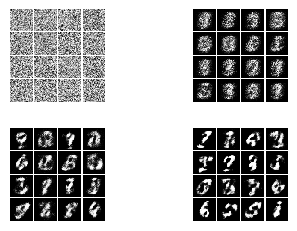

In [13]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-WGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-WGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-WGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-WGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

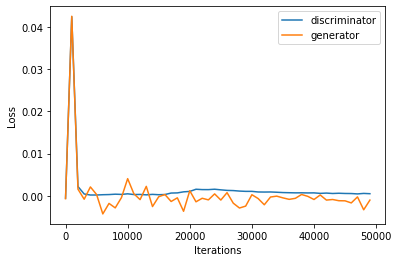

In [14]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()